**En este analisis se tomarán los datos de la búsqueda bicileta, el mismo intentará analizar si se puede encontar la mejor performance en relacion precio, calidad, producto y servicio.**

In [5]:
%pip install pandas
%pip install requests
%pip install json
%pip install matplotlib

You should consider upgrading via the '/home/oss/anaconda3/bin/python3 -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


     |████████████████████▌           | 81 kB 3.3 MB/s eta 0:00:01

     |████████████████████████████████| 127 kB 2.9 MB/s 


  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.3
    Uninstalling urllib3-1.26.3:
      Successfully uninstalled urllib3-1.26.3


You should consider upgrading via the '/home/oss/anaconda3/bin/python3 -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


You should consider upgrading via the '/home/oss/anaconda3/bin/python3 -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the '/home/oss/anaconda3/bin/python3 -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


In [6]:
# Importamos los datos y los convertimos a un DataFrame.

import requests
import json

import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_columns = None

if __name__ == '__main__':
    url = 'https://api.mercadolibre.com/sites/MLA/search?q=Bicileta'
    response =requests.get(url)
    
    if response.status_code == 200:
        content = response.content
        data = json.loads(content)
        dato = pd.json_normalize(data['results'])
        df = pd.DataFrame(dato)
        print(df.head(5))

             id site_id                                              title  \
0  MLA739946584     MLA  Bicicleta Nordic X1.0 By Slp R29 Shim. 21v Dis...   
1  MLA811741067     MLA  Bicicleta Mountain Bike Slp 5 R29 21v Shimano ...   
2  MLA601795056     MLA  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   
3  MLA605155761     MLA  Bicicleta Mountain Bike Rodado 29 Slp 5 - Camb...   
4  MLA817809270     MLA  Bicicleta Mtb Slp 5 Pro R29 21v Shimano F.disc...   

      price sale_price currency_id  available_quantity  sold_quantity  \
0  37599.06       None         ARS                  50            500   
1  50969.00       None         ARS                  50            500   
2  27844.00       None         ARS                   1            500   
3  48300.00       None         ARS                   1            500   
4  39207.00       None         ARS                  50            150   

  buying_mode listing_type_id                 stop_time condition  \
0  buy_it_now    gold_s

Revisamos el DataFrame y observamos el porcentaje de valores faltantes que tenemos

In [7]:
# lista de las variables que contienen valores perdidos
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

# determinar el porcentaje de valores perdidos
df[vars_with_na].isnull().mean()


sale_price                                                                    1.00
original_price                                                                0.36
official_store_id                                                             1.00
catalog_product_id                                                            0.46
seller.eshop.nick_name                                                        0.04
seller.eshop.eshop_rubro                                                      1.00
seller.eshop.eshop_id                                                         0.04
seller.eshop.eshop_locations                                                  0.04
seller.eshop.site_id                                                          0.04
seller.eshop.eshop_logo_url                                                   0.04
seller.eshop.eshop_status_id                                                  0.04
seller.eshop.seller                                                           0.04
sell

**Suelto las columnas que tienen un porcentaje mayor a  0.40 de valores faltantes**

In [8]:
df = df.drop(['sale_price', 'official_store_id', 'catalog_product_id', 
              'seller.eshop.eshop_rubro', 'address.city_id', 'seller_address.city.id',
               'differential_pricing.id'], axis=1)

df.head()


,id,site_id,title,price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,permalink,thumbnail,thumbnail_id,accepts_mercadopago,attributes,original_price,category_id,domain_id,tags,order_backend,use_thumbnail_id,seller.id,seller.permalink,seller.registration_date,seller.car_dealer,seller.real_estate_agency,seller.tags,seller.eshop.nick_name,seller.eshop.eshop_id,seller.eshop.eshop_locations,seller.eshop.site_id,seller.eshop.eshop_logo_url,seller.eshop.eshop_status_id,seller.eshop.seller,seller.eshop.eshop_experience,seller.seller_reputation.transactions.total,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.period,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.completed,seller.seller_reputation.power_seller_status,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.claims.period,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.delayed_handling_time.period,seller.seller_reputation.metrics.sales.period,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.seller_reputation.metrics.cancellations.period,seller.seller_reputation.level_id,prices.id,prices.prices,prices.presentation.display_currency,prices.payment_method_prices,installments.quantity,installments.amount,installments.rate,installments.currency_id,address.state_id,address.state_name,address.city_name,shipping.free_shipping,shipping.mode,shipping.tags,shipping.logistic_type,shipping.store_pick_up,seller_address.id,seller_address.comment,seller_address.address_line,seller_address.zip_code,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.name,seller_address.latitude,seller_address.longitude,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.protection_end_date,seller.seller_reputation.real_level
0,MLA739946584,MLA,Bicicleta Nordic X1.0 By Slp R29 Shim. 21v Dis...,37599.06,ARS,50,500,buy_it_now,gold_special,2040-11-23T19:30:14.000Z,new,https://articulo.mercadolibre.com.ar/MLA-73994...,http://http2.mlstatic.com/D_692447-MLA41937049...,692447-MLA41937049812_052020,True,"[{'value_id': '5411077', 'value_struct': None,...",39999.0,MLA6143,MLA-BICYCLES,"[good_quality_picture, good_quality_thumbnail,...",1,False,70513647,http://perfil.mercadolibre.com.ar/GARIOTTI,2004-06-29T12:03:26.000-04:00,False,False,"[normal, user_info_verified, eshop, mshops, cr...",GARIOTTI,41671.0,[],MLA,http://resources.mlstatic.com/eshops/70513647v...,1.0,70513647.0,0.0,120317,6379,historic,0.04,0.93,0.03,113938,platinum,0.0099,171,60 days,0.0028,47,60 days,60 days,16349,0.0032,55,60 days,5_green,MLA739946584,[{'id': '72924fed-9780-43f0-9189-7be97daee343'...,ARS,[],12,5331.86,70.17,ARS,AR-B,Buenos Aires,Lomas de Zamora,True,me2,[mandatory_free_shipping],cross_docking,False,,,,,AR,Argentina,AR-B,Buenos Aires,Lomas de Zamora,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MLA811741067,MLA,Bicicleta Mountain Bike Slp 5 R29 21v Shimano ...,50969.00,ARS,50,500,buy_it_now,gold_pro,2040-06-19T15:10:00.000Z,new,https://articulo.mercadolibre.com.ar/MLA-81174...,http://http2.mlstatic.com/D_649463-MLA41826821...,649463-MLA41826821808_052020,True,"[{'name': 'Marca', 'value_name':

**Reviso las columnas que cuentas con valores categoricos**

In [9]:
# Inserto en una lista los valores categoricos
cat_vars = [var for var in df.columns if df[var].dtypes == 'O']

print('Cantidad de variables categoricas: ', len(cat_vars))

# Visualizo los valores categoricos
df[cat_vars].head()


Cantidad de variables categoricas:  53


,id,site_id,title,currency_id,buying_mode,listing_type_id,stop_time,condition,permalink,thumbnail,thumbnail_id,attributes,category_id,domain_id,tags,seller.permalink,seller.registration_date,seller.tags,seller.eshop.nick_name,seller.eshop.eshop_locations,seller.eshop.site_id,seller.eshop.eshop_logo_url,seller.seller_reputation.transactions.period,seller.seller_reputation.power_seller_status,seller.seller_reputation.metrics.claims.period,seller.seller_reputation.metrics.delayed_handling_time.period,seller.seller_reputation.metrics.sales.period,seller.seller_reputation.metrics.cancellations.period,seller.seller_reputation.level_id,prices.id,prices.prices,prices.presentation.display_currency,prices.payment_method_prices,installments.currency_id,address.state_id,address.state_name,address.city_name,shipping.mode,shipping.tags,shipping.logistic_type,seller_address.id,seller_address.comment,seller_address.address_line,seller_address.zip_code,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.name,seller_address.latitude,seller_address.longitude,seller.seller_reputation.protection_end_date,seller.seller_reputation.real_level
0,MLA739946584,MLA,Bicicleta Nordic X1.0 By Slp R29 Shim. 21v Dis...,ARS,buy_it_now,gold_special,2040-11-23T19:30:14.000Z,new,https://articulo.mercadolibre.com.ar/MLA-73994...,http://http2.mlstatic.com/D_692447-MLA41937049...,692447-MLA41937049812_052020,"[{'value_id': '5411077', 'value_struct': None,...",MLA6143,MLA-BICYCLES,"[good_quality_picture, good_quality_thumbnail,...",http://perfil.mercadolibre.com.ar/GARIOTTI,2004-06-29T12:03:26.000-04:00,"[normal, user_info_verified, eshop, mshops, cr...",GARIOTTI,[],MLA,http://resources.mlstatic.com/eshops/70513647v...,historic,platinum,60 days,60 days,60 days,60 days,5_green,MLA739946584,[{'id': '72924fed-9780-43f0-9189-7be97daee343'...,ARS,[],ARS,AR-B,Buenos Aires,Lomas de Zamora,me2,[mandatory_free_shipping],cross_docking,,,,,AR,Argentina,AR-B,Buenos Aires,Lomas de Zamora,,,NaN,NaN
1,MLA811741067,MLA,Bicicleta Mountain Bike Slp 5 R29 21v Shimano ...,ARS,buy_it_now,gold_pro,2040-06-19T15:10:00.000Z,new,https://articulo.mercadolibre.com.ar/MLA-81174...,http://http2.mlstatic.com/D_649463-MLA41826821...,649463-MLA41826821808_052020,"[{'name': 'Marca', 'value_name': 'SLP', 'value...",MLA6143,MLA-BICYCLES,"[ahora-12, brand_verified, good_quality_pictur...",http://perfil.mercadolibre.com.ar/STI_BICICLETAS,2018-04-30T11:43:15.000-04:00,"[normal, user_info_verified, credits_profile, ...",STI_BICICLETAS,[],MLA,http://resources.mlstatic.com/eshops/317973780...,historic,platinum,60 days,60 days,60 days,60 days,5_green,MLA811741067,"[{'id': '27', 'type': 'standard', 'conditions'...",ARS,[],ARS,AR-C,Capital Federal,Mataderos,me2,"[self_service_in, mandatory_free_shipping]",cross_docking,,,,,AR,Argentina,AR-C,Capital Federal,Mataderos,,,NaN,NaN
2,MLA601795056,MLA,Bicicleta Mountain Bike Rodado 26 Doble Suspen...,ARS,buy_it_now,gold_special,2040-11-25T11:48:15.000Z,new,https://articulo.mercadolibre.com.ar/MLA-60179...,http://http2.mlstatic.com/D_749873-MLA32928923...,749873-MLA32928923578_112019,"[{'value_id': None, 'value_name': 'Forest', 'v...",MLA6143,MLA-BICYCLES,"[dragged_bids_and_visits, good_quality_picture...",http://perfil.mercadolibre.com.ar/HAPPY--BUY,2007-01-07T13:28:59.000-04:00,"[normal, user_info_verified, eshop, medium_sel...",HAPPY--BUY,[],MLA,http://resources.mlstatic.com/eshops/3255473v4...,historic,platinum,60 days,60 days,60 days,60 days,5_green,MLA601795056,"[{'id': '19', 'type': 'standard', 'conditions'...",ARS,[],ARS,AR-C,Capital Federal,Buenos Aires,me2,"[fulfillment, self_service_out, mandatory_free...",fulfillment,,,,,AR,Argentina,AR-C,Capital Federal,Buenos Aires,,,NaN,NaN
3,MLA605155761,MLA,Bicicleta Mountain Bike Rodado 29 Slp 5 - Camb...,ARS,buy_it_now,gold_pro,2039-01-04T18:41:37.000Z,new,https://articulo.mercadolibre.com.ar/MLA-60515...,http://http2.mlstatic.com/D_927488-MLA44

**Remplazo valores faltantes con 0**

In [10]:
df = df.apply(lambda serie: serie.fillna(0), axis=0)


**Revisamos en una tabla de contingencia la relación que se encuentra entre price/original\_price. Podemos observar que precios ofrecen descuento en sus publicaciones**

In [11]:
pd.crosstab(index=df['price'],
            columns=df['original_price'], margins=True)

original_price,0.0,24300.0,30375.0,33075.0,39999.0,40000.0,42188.0,45410.0,45989.0,48938.0,49739.0,50819.0,51299.0,51998.0,54828.0,56850.0,60306.0,62385.0,62996.0,62999.0,67639.0,71818.6,73905.0,75000.0,79499.0,84170.0,85598.0,87931.0,88550.0,91838.6,104249.0,All
price,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9200.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12289.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16790.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
18000.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
19076.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
24500.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25998.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
26800.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**Ahora observamos un gráfico de barras de frecuencia relativa entre price y original\_price.**

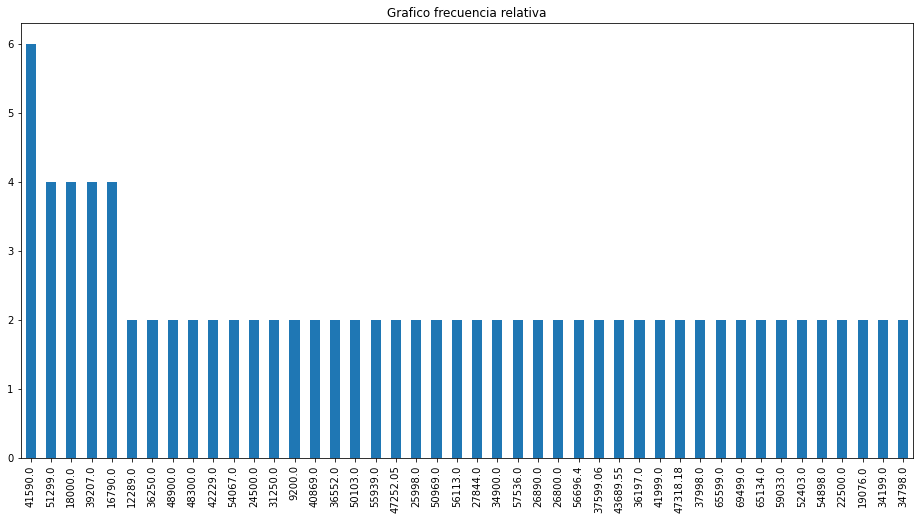

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,8))

plot = (100 * df['price'].value_counts() / len(df['original_price'])).plot(
kind='bar', title='Grafico frecuencia relativa')

**Graficamos la distribución de los vendedores para poder identificar si existe mayor incidencia de un lugar a otro,**

**podemos observar que el mayor porcentaje de vendedores se encuentra en CABA seguido por provincia de Buenos Aires.**

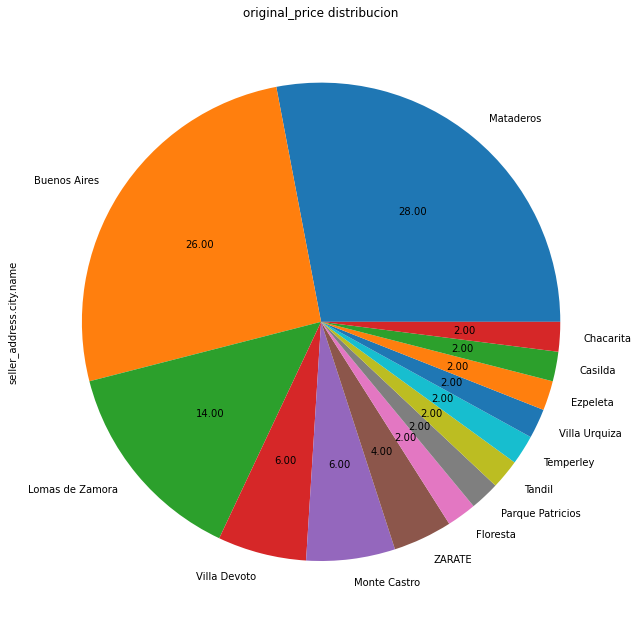

In [13]:
plot = df['seller_address.city.name'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(11, 11),
                                            title='original_price distribucion')

**Ahora graficamos la relacion entre ubicación y tipo de usuario (listing\_type\_i). Podemos observar que todos los usuarios gold\_pro se distribuyen practicamente todos entre CABA y lomas de zamora (gran Buenos  aires),  mientras que los usuarios gold\_special se distribuyen tanto en CABA y gran** **Buenos aires.**

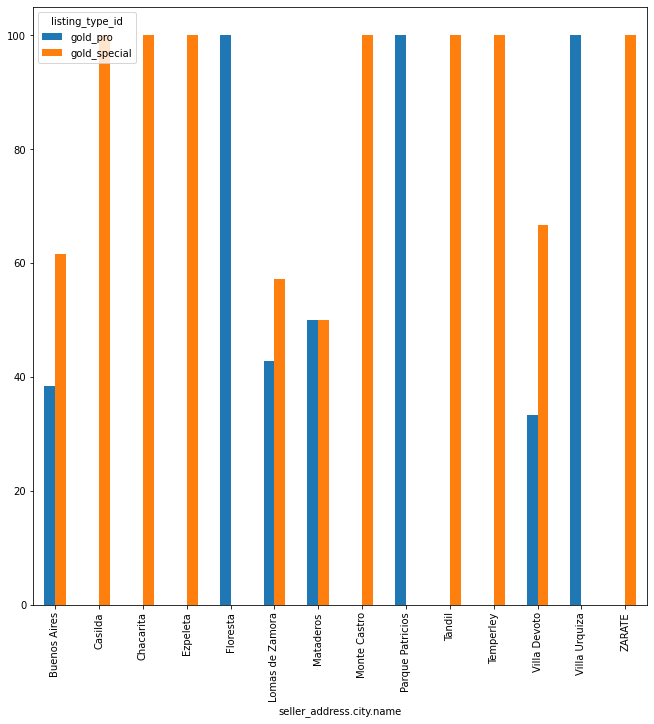

In [14]:
# Gráfico de barras de original_price según ciudad de vendedor
# Podemos ver que los usuarios gold_pro se concentran en CABA mientras que los vendedores de gold_special
# se distirbuyen entre Buenos Aires y Gran Buenos Aires.

plot = pd.crosstab(index=df['seller_address.city.name'], 
            columns=df['listing_type_id']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar', figsize=(11, 11))

**Analizamos y graficamos si existe una relacion según la clase de vendedor y tipo de usuario (listing\_type\_id).Podemos ver que los usuarios**

**gold\_pro tienen preponderancia absoluta en la relacion price/original\_price lo que puede traducirse en que comercializan con las bicicletas**

**de mayor valor mientras que los usuarios gold\_special tienen preponderancia en la relacion price/original\_price de gama baja y media.**

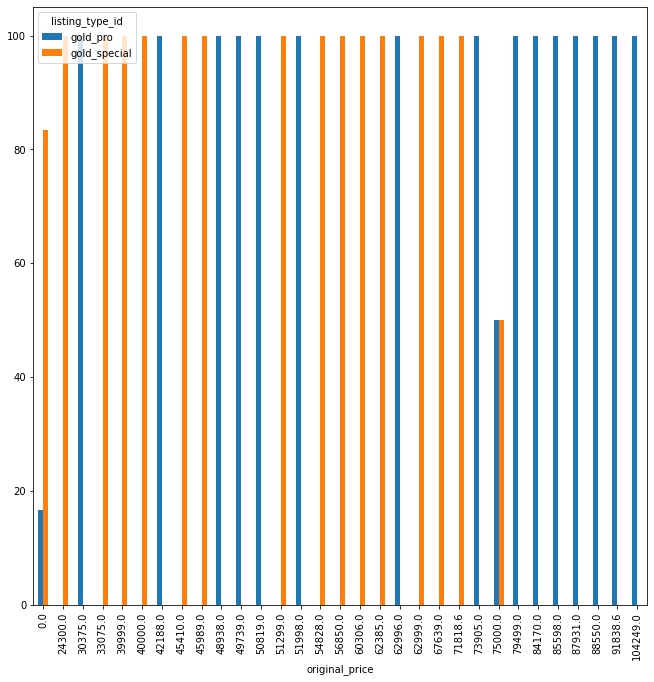

In [15]:
plot = pd.crosstab(index=df['original_price'], 
            columns=df['listing_type_id']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar', figsize=(11, 11),)

**Ahora intentaremos  determinar si existe una relación entre la cantidad de ventas según su original\_price. Podemos observar que el mayor volumen se centra en bicicletas sin original\_price, mientras que la distribución de los productos que si poseen original\_price podemos identificarlos mayormente en productos de valor medio.**

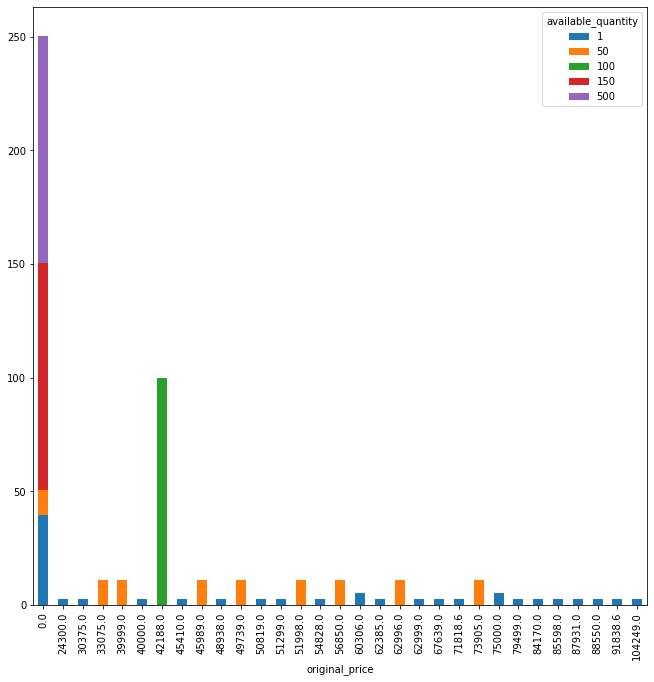

In [16]:
plot = pd.crosstab(index=df['original_price'],
            columns=df['available_quantity']
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, figsize=(11, 11))

**Ahora veremos la relación entre el tipo de producto y su original\_price, podemos observar que la oferta en la bicicleta Nordic X 3.0 R29 es la única que destaca por una mayor oferta.**

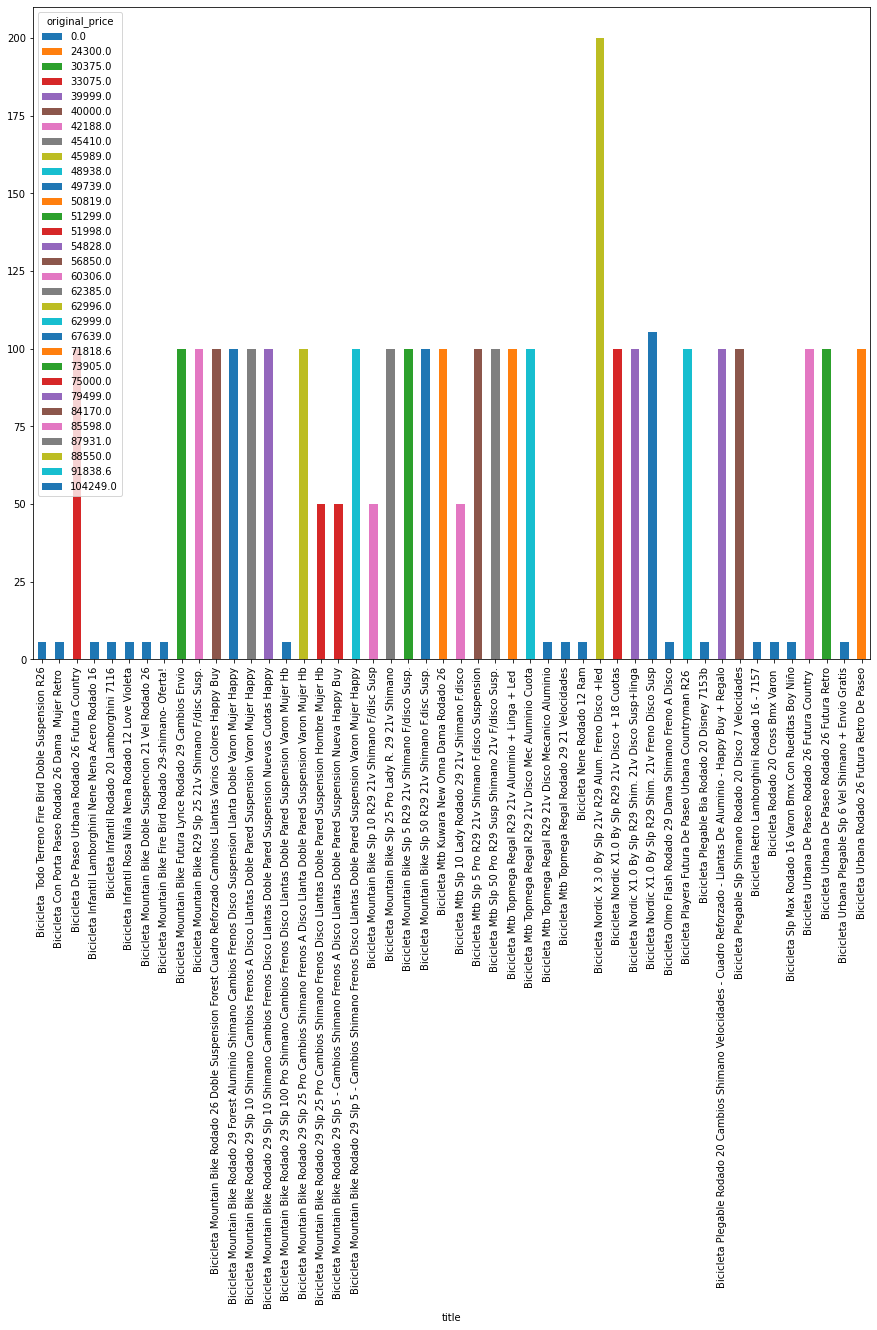

In [17]:
# Gráfico de barras de sobreviviviente segun clase
plot = pd.crosstab(index=df['title'], 
            columns=df['original_price']
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, figsize=(15, 12))



**Ahora exploraremos que porcentaje de descuento tiene mayor incidencia en las ventas,  podemos observar como los valores del 35% y %50 toman notoria relevancia en comparación al resto.**

In [18]:
df['descuento'] = ((df['price'] - df['original_price']) *100)/df['price']
df = df.round(0)

df = df.sort_values(by=['descuento'], ascending=False)

pd.crosstab(index=df['sold_quantity'],
            columns=df['descuento'], margins=True)



descuento,-78.0,-61.0,-55.0,-50.0,-47.0,-45.0,-44.0,-40.0,-35.0,-21.0,-11.0,-10.0,-6.0,-5.0,100.0,All
sold_quantity,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
5,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,4
25,0,0,0,1,0,0,0,0,1,0,0,0,0,0,4,6
50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3
100,0,0,0,0,0,0,0,0,2,0,0,1,0,0,6,9
150,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,3
200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2
250,0,0,0,0,0,2,0,0,3,1,1,0,0,1,2,10


**Conclusión:**

**Podemos identificar a dos grupos de vendedores que predominan según su original\_price, siendo que el grupo A se focaliza en una relación precio/calidad alta (gama alta) mientras que el grupo B se centra en la relacón cantidad/precio optimo. En todos los casos el env{i es gratuito. Notamos que la ubicación que pondera es CABA siendo el mayor lugar en la oferta de original\_price, mientras que el producto más comercializado es la** **bicicleta Nordic X 3.0 R29 y los valores en los cuales original price parece ser mas efectivo son 35% (6 unidades) y 50% (7 unidades).**